In [1105]:
import pandas as pd

!pip3 install catboost
from catboost import CatBoostRegressor


In [1106]:
# population get
Population_file_path = 'Distance.xlsx'
population = pd.read_excel(Population_file_path, sheet_name='Population_quart')
population = list(population.Population)

number_of_quarts = len(population)

In [1107]:
# distance get
Distance_file_path = 'Distance.xlsx'
distance = pd.read_excel(Distance_file_path, sheet_name='Distance_from_quart', index_col='Id')

distance_from_market = {}
ids = []
for Id in distance.columns:
    distance_from_market[Id] = list(distance[Id])
    ids.append(Id)

In [1108]:
# market data get

Markets_file_path = 'Market_data_changed3.xlsx'
market_data = pd.read_excel(Markets_file_path, index_col='Full_Address')

Coord_file_path = 'Coord.xlsx'
coord = pd.read_excel(Coord_file_path, index_col='Full_Address')

market_data = market_data.join(coord)

market_data = market_data.reset_index()
market_data.head()

,Full_Address,Type,Square,Categorical_Brand,Traffic,Time,Building_Type,Frequency,Id,lat,lon
0,1 Капитанская ул. Санкт-Петербург,супермаркет,628.0,Пятерочка,33652,31,жилой дом,1085.548387,235,30.215445,59.955417
1,1 Новосмоленская набережная Санкт-Петербург,магазин,126.0,Другие,4586,51,жилой дом,89.921569,118,30.230887,59.949145
2,1 Новосмоленская набережная Санкт-Петербург,магазин,137.0,Другие,7417,31,жилой дом,239.258065,118,30.230887,59.949145
3,10 Среднегаванский проспект Санкт-Петербург,магазин,232.0,Другие,8791,30,жилой дом,293.033333,150,30.244919,59.930449
4,100 Средний проспект В.О. Санкт-Петербург,лавка,20.0,Другие,4098,31,жилой дом,132.193548,152,30.241092,59.931648


In [1109]:
# square get

square_of_market = []
for row in market_data.iterrows():
    square_of_market.append({'Id': row[1]['Id'], 'Square': row[1]['Square']})

number_of_markets = len(square_of_market)

square_of_market

[{'Id': 235, 'Square': 628.0},
 {'Id': 118, 'Square': 126.0},
 {'Id': 118, 'Square': 137.0},
 {'Id': 150, 'Square': 232.0},
 {'Id': 152, 'Square': 20.0},
 {'Id': 152, 'Square': 131.0},
 {'Id': 138, 'Square': 295.0},
 {'Id': 249, 'Square': 255.0},
 {'Id': 120, 'Square': 253.7},
 {'Id': 122, 'Square': 251.0},
 {'Id': 133, 'Square': 410.0},
 {'Id': 159, 'Square': 839.0},
 {'Id': 27, 'Square': 221.0},
 {'Id': 202, 'Square': 418.0},
 {'Id': 143, 'Square': 129.0},
 {'Id': 84, 'Square': 238.0},
 {'Id': 84, 'Square': 103.0},
 {'Id': 84, 'Square': 20.0},
 {'Id': 237, 'Square': 430.0},
 {'Id': 243, 'Square': 955.0},
 {'Id': 256, 'Square': 188.0},
 {'Id': 224, 'Square': 951.0},
 {'Id': 44, 'Square': 86.0},
 {'Id': 130, 'Square': 242.0},
 {'Id': 222, 'Square': 569.0},
 {'Id': 23, 'Square': 216.0},
 {'Id': 196, 'Square': 175.0},
 {'Id': 297, 'Square': 699.0},
 {'Id': 220, 'Square': 634.0},
 {'Id': 203, 'Square': 517.0},
 {'Id': 183, 'Square': 935.0},
 {'Id': 258, 'Square': 158.0},
 {'Id': 201, 'Squ

In [1110]:
# Huff gravity model

# i - number of quart, j- number of market
def huff_probability(i, j, lmbd=0.1):
    Id = square_of_market[j]['Id']
    s_t = square_of_market[j]['Square'] / distance_from_market[Id][i] ** lmbd

    sum_s_t = 0

    for market in square_of_market:
        sum_s_t += market['Square'] / distance_from_market[market['Id']][i] ** lmbd

    return s_t / sum_s_t


huff_pred_by_market = []

for j in range(number_of_markets):
    byuers_count = 0
    for i in range(number_of_quarts):
        prob = huff_probability(i, j)
        byuers_count += prob * population[i]
    huff_pred_by_market.append(byuers_count)

In [1111]:
# Huff insertion in DataFrame

market_data.insert(0, 'Huff', huff_pred_by_market)
market_data.head()

,Huff,Full_Address,Type,Square,Categorical_Brand,Traffic,Time,Building_Type,Frequency,Id,lat,lon
0,3104.112486,1 Капитанская ул. Санкт-Петербург,супермаркет,628.0,Пятерочка,33652,31,жилой дом,1085.548387,235,30.215445,59.955417
1,635.376431,1 Новосмоленская набережная Санкт-Петербург,магазин,126.0,Другие,4586,51,жилой дом,89.921569,118,30.230887,59.949145
2,690.845802,1 Новосмоленская набережная Санкт-Петербург,магазин,137.0,Другие,7417,31,жилой дом,239.258065,118,30.230887,59.949145
3,1137.841836,10 Среднегаванский проспект Санкт-Петербург,магазин,232.0,Другие,8791,30,жилой дом,293.033333,150,30.244919,59.930449
4,98.691336,100 Средний проспект В.О. Санкт-Петербург,лавка,20.0,Другие,4098,31,жилой дом,132.193548,152,30.241092,59.931648


In [1112]:
# Features and Target

X = market_data
y = market_data['Frequency']
X = X.drop(['Frequency'], axis=1)

X = X.drop(['Full_Address'], axis=1)
#X = X.drop(['Square'], axis=1)
#X = X.drop(['Huff'], axis=1)
X = X.drop(['Traffic'], axis=1)
X = X.drop(['Time'], axis=1)
X = X.drop(['Id'], axis=1)
X = X.drop(['lat'], axis=1)
X = X.drop(['lon'], axis=1)
#X = X.drop(['Type'], axis=1)
#X = X.drop(['Categorical_Brand'], axis=1)
#X = X.drop(['Building_Type'], axis=1)


categorical_cols = [col for col in X.columns if X[col].dtype == 'object']
numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]

X.head()

,Huff,Type,Square,Categorical_Brand,Building_Type
0,3104.112486,супермаркет,628.0,Пятерочка,жилой дом
1,635.376431,магазин,126.0,Другие,жилой дом
2,690.845802,магазин,137.0,Другие,жилой дом
3,1137.841836,магазин,232.0,Другие,жилой дом
4,98.691336,лавка,20.0,Другие,жилой дом


In [1113]:
# setting up cross_validation

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score


def get_score(model):
    numerical_transformer = SimpleImputer(strategy='constant')
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

    cross_val_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    scores = -1 * cross_val_score(cross_val_pipeline, X, y, cv=25, scoring='neg_mean_absolute_percentage_error')
    return scores.mean()

In [1114]:
# testing different models

In [1115]:
from xgboost import XGBRegressor

model_grad = XGBRegressor(max_depth=5, n_estimators=100, learning_rate=0.04, random_state=44)
get_score(model_grad)


0.511898180080088

In [1116]:
from sklearn.ensemble import RandomForestRegressor

model_forest = RandomForestRegressor(n_estimators=150, random_state=44)
get_score(model_forest)

0.5522355702855697

In [1117]:
from sklearn.linear_model import LinearRegression

model_line = LinearRegression()
get_score(model_line)

0.5435236812548228

In [1118]:
from sklearn.linear_model import Ridge

model_ridge = Ridge()
get_score(model_ridge)

0.5742099421668808

In [1119]:
from sklearn.linear_model import Lasso

model_lasso = Lasso(max_iter=100000)
get_score(model_lasso)

0.5389353426266887

In [1120]:
from sklearn.linear_model import ElasticNet

model_elastic = ElasticNet(max_iter=100000)
get_score(model_elastic)

0.8066311505036226

In [1121]:
from sklearn.model_selection import train_test_split

Xgb_train, Xgb_test, ygb_train, ygb_test = train_test_split(X, y, train_size=0.85, test_size=0.15, random_state=4)

In [1122]:
model_catboost = CatBoostRegressor(depth=5, num_trees=130, learning_rate=0.4, eval_metric='MAPE')
model_catboost.fit(Xgb_train, ygb_train, cat_features=categorical_cols, eval_set=(Xgb_test, ygb_test))

0:	learn: 1.1166103	test: 1.0539178	best: 1.0539178 (0)	total: 25.4ms	remaining: 3.27s
1:	learn: 0.9118066	test: 0.8131095	best: 0.8131095 (1)	total: 46.2ms	remaining: 2.96s
2:	learn: 0.7957278	test: 0.6840784	best: 0.6840784 (2)	total: 64.8ms	remaining: 2.74s
3:	learn: 0.7017621	test: 0.5903439	best: 0.5903439 (3)	total: 82.4ms	remaining: 2.59s
4:	learn: 0.6424505	test: 0.5450452	best: 0.5450452 (4)	total: 101ms	remaining: 2.52s
5:	learn: 0.6110617	test: 0.5109903	best: 0.5109903 (5)	total: 113ms	remaining: 2.34s
6:	learn: 0.5835028	test: 0.4901503	best: 0.4901503 (6)	total: 142ms	remaining: 2.5s
7:	learn: 0.5606337	test: 0.4840710	best: 0.4840710 (7)	total: 174ms	remaining: 2.65s
8:	learn: 0.5350427	test: 0.4833680	best: 0.4833680 (8)	total: 187ms	remaining: 2.51s
9:	learn: 0.5326594	test: 0.4779053	best: 0.4779053 (9)	total: 217ms	remaining: 2.6s
10:	learn: 0.5138542	test: 0.4731311	best: 0.4731311 (10)	total: 240ms	remaining: 2.6s
11:	learn: 0.4950059	test: 0.4608382	best: 0.460838

In [1123]:
from sklearn.metrics import mean_absolute_percentage_error

Y_predict = model_catboost.predict(X)
Y_pred = model_catboost.predict(Xgb_test)
print(mean_absolute_percentage_error(y, Y_predict))
print(mean_absolute_percentage_error(ygb_test, Y_pred))

0.44452466810629726
0.43760591198172766


In [1124]:
X = pd.get_dummies(X, columns=categorical_cols)

In [1125]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.85, test_size=0.15, random_state=44)

In [1126]:
#PyTorch model_ln train

import torch
from torch import nn
from torch.autograd import Variable
from torchmetrics import MeanAbsolutePercentageError

torch.manual_seed(44)

x_data = Variable(torch.Tensor(X_train.values))
y_data = Variable(torch.Tensor([[target] for target in y_train.values]))


class LinearRegressionModel(torch.nn.Module):

    def __init__(self):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(len(x_data[0]), 1)

    def forward(self, x):
        y_pred = self.linear(x)
        return y_pred


torch_model_ln = LinearRegressionModel()

loss_fn_ln = MeanAbsolutePercentageError()
optimizer_ln = torch.optim.Adam(torch_model_ln.parameters(), lr=0.04)

for epoch in range(50000):
    # Forward pass: Compute predicted y by passing
    # x to the model
    pred_y = torch_model_ln(x_data)

    # Compute and print loss
    loss_ln = loss_fn_ln(pred_y, y_data)

    # Zero gradients, perform a backward pass,
    # and update the weights.
    optimizer_ln.zero_grad()
    loss_ln.backward()
    optimizer_ln.step()
    # print('epoch {}, loss {}'.format(epoch, loss_ln.item()))

In [1127]:
#PyTorch model_nn train
torch.manual_seed(44)

class NeuralNetwork(torch.nn.Module):

    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(len(x_data[0]), 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        y_pred = self.layers(x)
        return y_pred


torch_model_nn = NeuralNetwork()

loss_fn_nn = MeanAbsolutePercentageError()
optimizer_nn = torch.optim.Adam(torch_model_nn.parameters(), lr=0.04)

for epoch in range(50000):
    # Forward pass: Compute predicted y by passing
    # x to the model
    pred_y = torch_model_nn(x_data)

    # Compute and print loss
    loss_nn = loss_fn_nn(pred_y, y_data)

    # Zero gradients, perform a backward pass,
    # and update the weights.
    optimizer_nn.zero_grad()
    loss_nn.backward()
    optimizer_nn.step()
    # print('epoch {}, loss {}'.format(epoch, loss_nn.item()))

In [1128]:
#py_torch model validation

x_data_all = Variable(torch.Tensor(X.values))
y_data_all = Variable(torch.Tensor([[target] for target in y.values]))


x_data_valid = Variable(torch.Tensor(X_valid.values))
y_data_valid = Variable(torch.Tensor([[target] for target in y_valid.values]))

In [1129]:
import matplotlib.pyplot as plt

In [1130]:
def compare_valid_torch(m_model, loss):
    m_predictions = m_model(x_data_valid)
    m_predictions_all = m_model(x_data_all)

    fig1 = plt.figure(figsize=(12, 5))
    fig2 = plt.figure(figsize=(7, 6))

    ax2 = fig1.add_subplot(111)
    ax = fig2.add_subplot(211)

    ax.plot(list(i for i in range(len(y_valid))), list(y_valid))
    ax.plot(list(i for i in range(len(y_valid))), m_predictions.tolist())

    ax2.plot(list(i for i in range(len(y))), list(y))
    ax2.plot(list(i for i in range(len(y))), m_predictions_all.tolist())

    plt.show()

    loss_valid = loss(m_predictions, y_data_valid)
    loss_all = loss(m_predictions_all, y_data_all)

    print(loss_valid.item())
    print('all data:', loss_all.item())

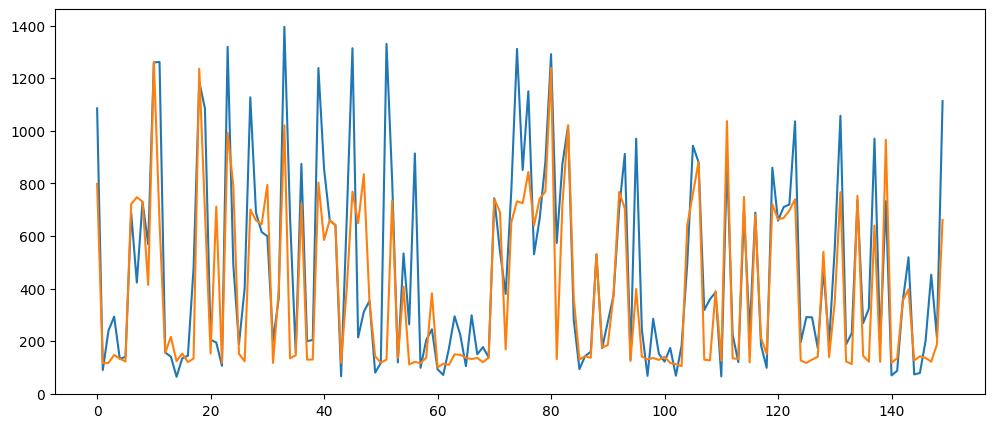

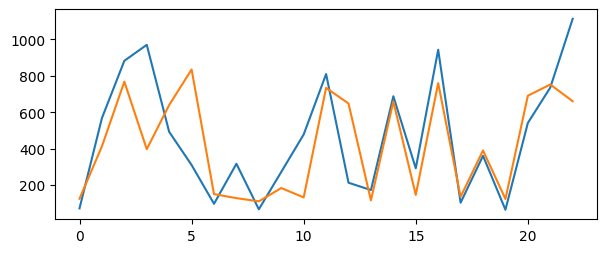

0.5080955624580383
all data: 0.35019952058792114


In [1131]:
compare_valid_torch(torch_model_ln, loss_fn_ln)

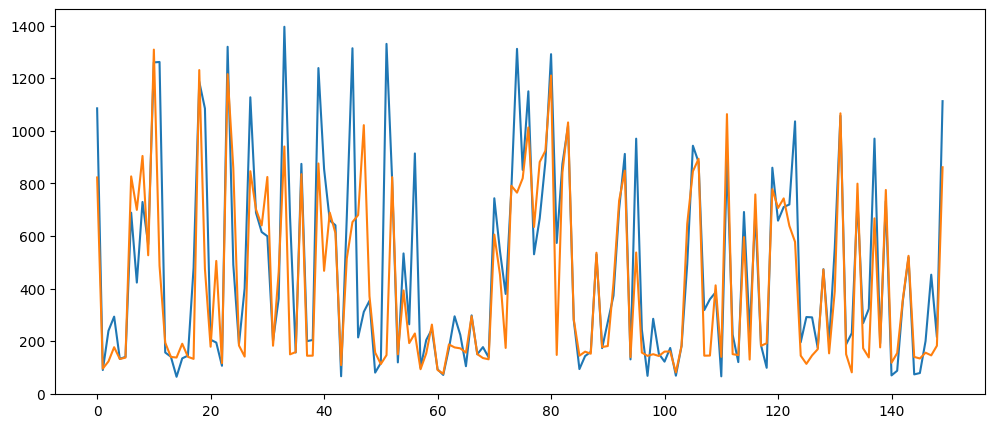

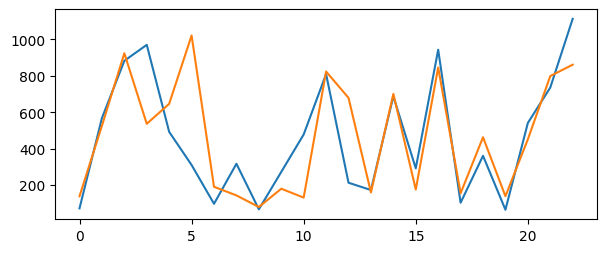

0.5208101272583008
all data: 0.3088955581188202


In [1132]:
compare_valid_torch(torch_model_nn, loss_fn_nn)

In [1133]:
def compare_valid(m_model):
    m_model.fit(X_train, y_train)
    m_predictions = m_model.predict(X_valid)

    fig1 = plt.figure(figsize=(12, 5))
    fig2 = plt.figure(figsize=(7, 6))

    ax2 = fig1.add_subplot(111)
    ax = fig2.add_subplot(211)

    ax.plot(list(i for i in range(len(y_valid))), list(y_valid))
    ax.plot(list(i for i in range(len(y_valid))), list(m_predictions))

    ax2.plot(list(i for i in range(len(y))), list(y))
    ax2.plot(list(i for i in range(len(y))), list(m_model.predict(X)))

    plt.show()

    print(mean_absolute_percentage_error(y_valid, m_predictions))
    print('all data:', mean_absolute_percentage_error(y, m_model.predict(X)))

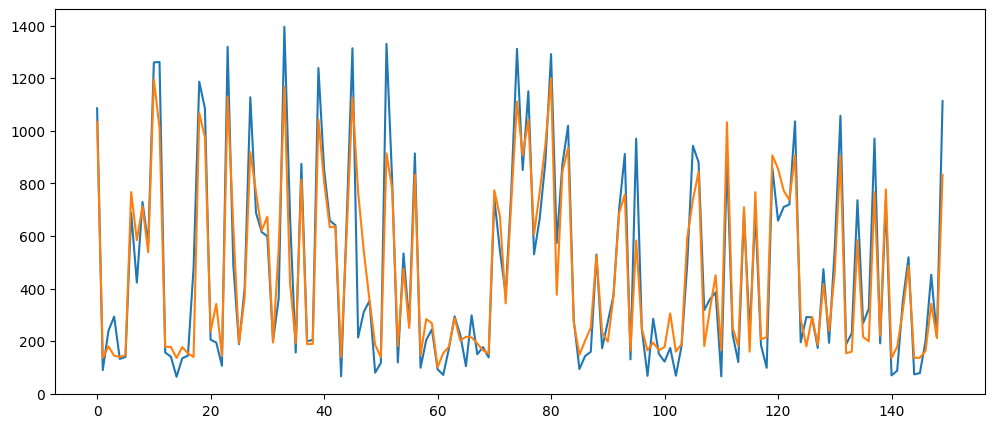

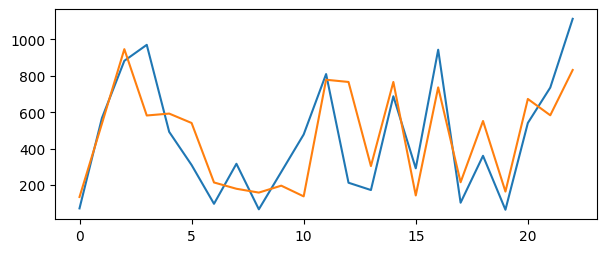

0.6219818949961169
all data: 0.28817708661408


In [1134]:
compare_valid(model_grad)

0:	learn: 1.0634464	total: 807us	remaining: 104ms
1:	learn: 0.8757769	total: 1.71ms	remaining: 110ms
2:	learn: 0.7225219	total: 2.43ms	remaining: 103ms
3:	learn: 0.6464773	total: 3.07ms	remaining: 96.7ms
4:	learn: 0.6016592	total: 3.48ms	remaining: 87.1ms
5:	learn: 0.5483391	total: 4.11ms	remaining: 84.8ms
6:	learn: 0.5200047	total: 4.8ms	remaining: 84.4ms
7:	learn: 0.5036197	total: 5.44ms	remaining: 83ms
8:	learn: 0.4972358	total: 6.11ms	remaining: 82.1ms
9:	learn: 0.4840901	total: 6.73ms	remaining: 80.8ms
10:	learn: 0.4794931	total: 7.34ms	remaining: 79.4ms
11:	learn: 0.4632987	total: 7.99ms	remaining: 78.5ms
12:	learn: 0.4482251	total: 8.65ms	remaining: 77.9ms
13:	learn: 0.4440824	total: 9.41ms	remaining: 78ms
14:	learn: 0.4392255	total: 10ms	remaining: 77ms
15:	learn: 0.4368189	total: 10.7ms	remaining: 76.4ms
16:	learn: 0.4315277	total: 11.5ms	remaining: 76.3ms
17:	learn: 0.4246936	total: 12.1ms	remaining: 75.6ms
18:	learn: 0.4218209	total: 12.8ms	remaining: 74.6ms
19:	learn: 0.419

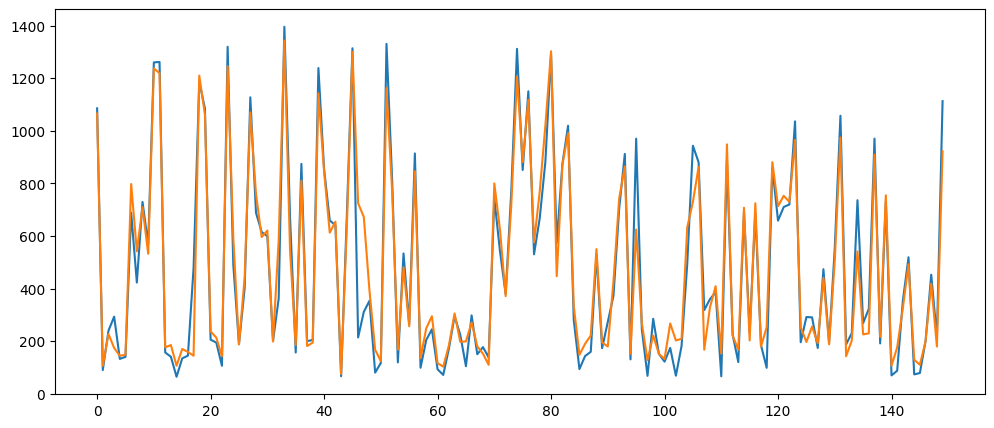

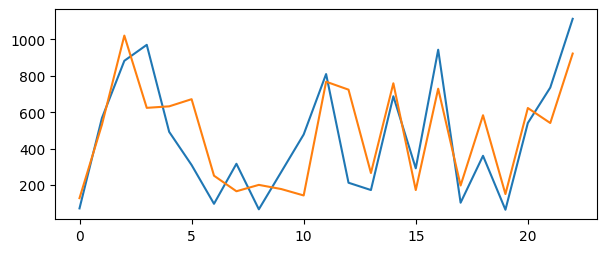

0.6502343132073107
all data: 0.22467978964345559


In [1135]:
compare_valid(model_catboost)

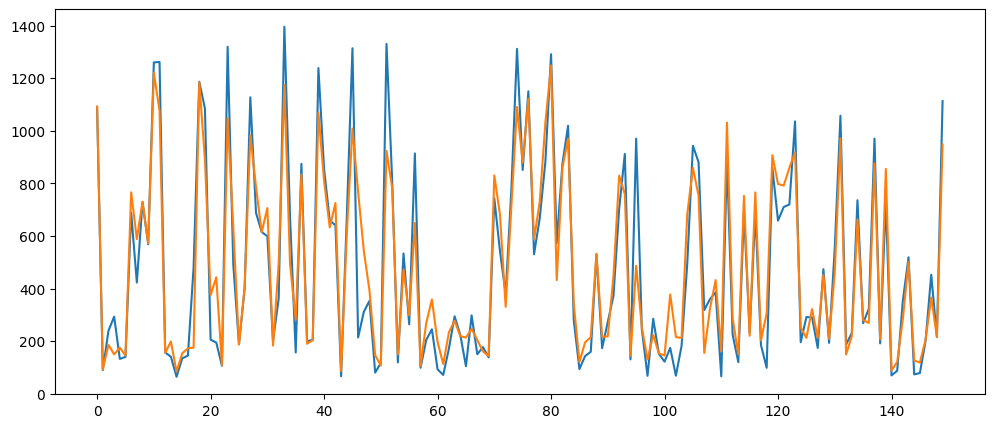

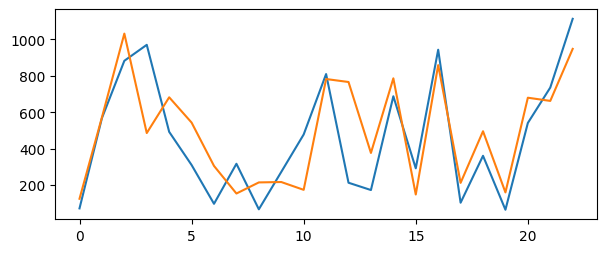

0.696490389342091
all data: 0.2680891297426347


In [1136]:
compare_valid(model_forest)

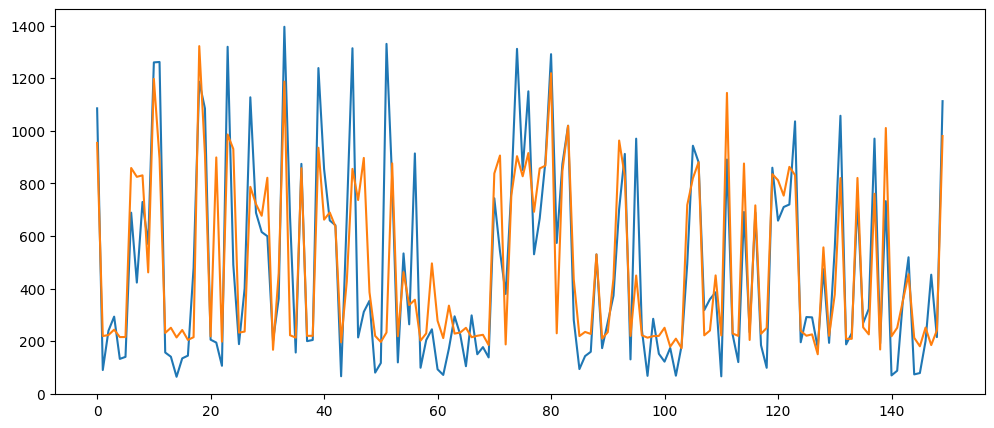

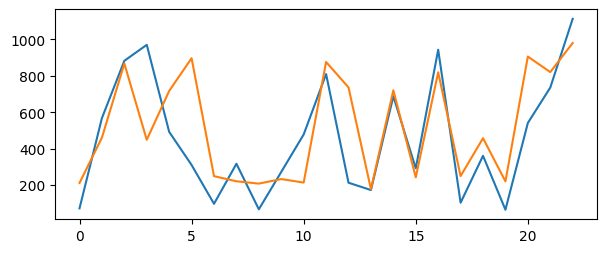

0.757399441271916
all data: 0.5077108149070896


In [1137]:
compare_valid(model_line)

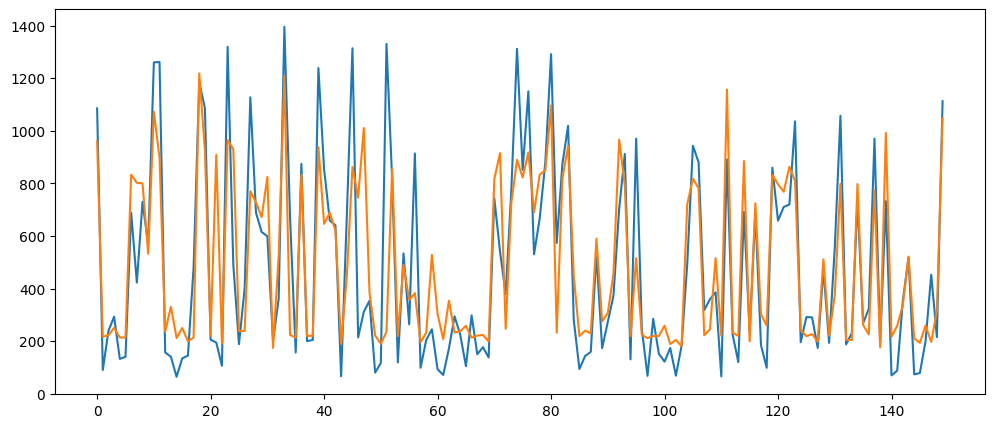

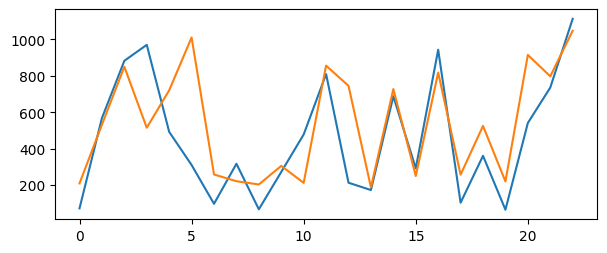

0.7752150499521472
all data: 0.5278737123428584


In [1138]:
compare_valid(model_ridge)

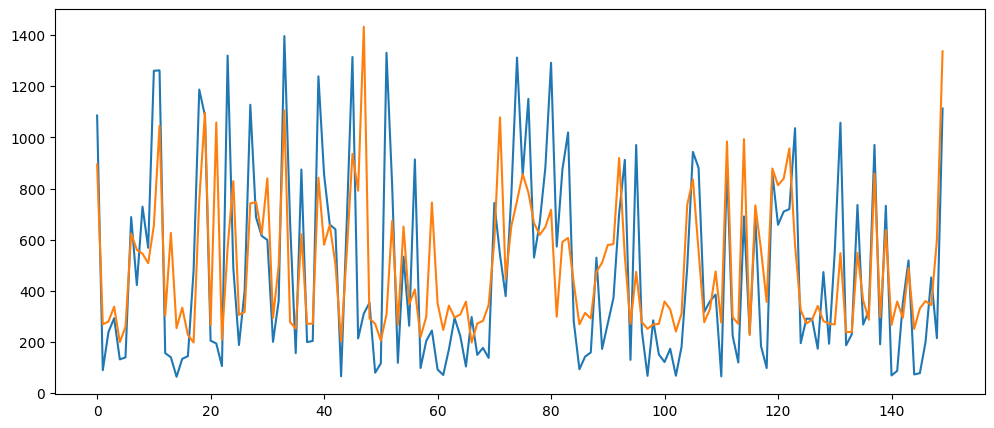

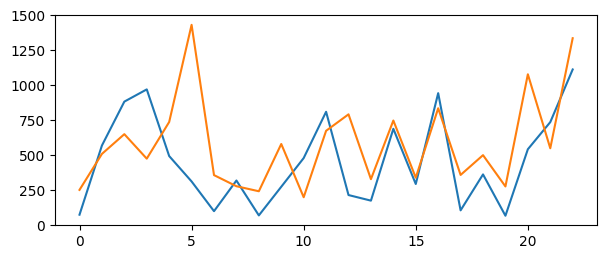

1.1278071394883935
all data: 0.7837723326005274


In [1139]:
compare_valid(model_elastic)

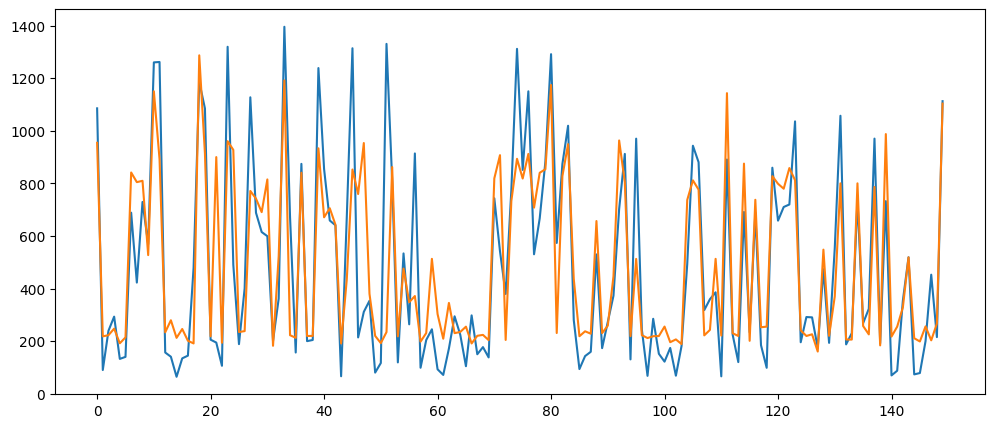

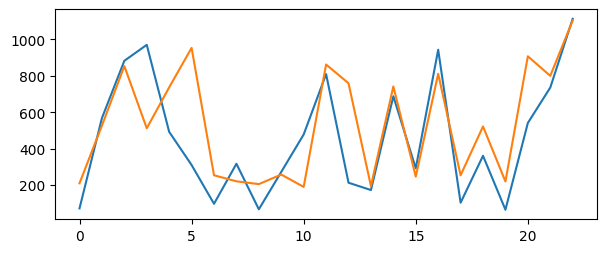

0.7701159984529502
all data: 0.5192201186567101


In [1140]:
compare_valid(model_lasso)